# Tariff suggestions

The mobile operator Megaline found out that many customers use archive tariffs. They want to build a system capable of analyzing customer behavior and offering users a new tariff: "Smart" or "Ultra".

We have at our disposal data on the behavior of customers who have already switched to these tariffs (from the course project "Statistical Data Analysis"). You need to build a model for the classification task that will choose the appropriate tariff. You won't need data preprocessing — you've already done it.

We need to build a model with the maximum accuracy value. To pass the project successfully, we need to bring the proportion of correct answers to at least 0.75. Check accuracy on the test sample ourself.

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Откройте и изучите файл

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


According to the information provided, each object in the dataset is information about the behavior of one user per month. Description:
- calls — number of calls,
- minutes — total duration of calls in minutes,
- messages — number of sms messages,
- mb_used — consumed internet traffic in MB,
- is_ultra — what tariff was used during the month ("Ultra" — 1, "Smart" — 0).

There are no missing values in the provided dataset. We will check the dataset for duplicates as standard.

In [4]:
df.duplicated().sum()

0

There are no obvious duplicates.
Let's look at the general description of the datase

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Considering that this task belongs to the classification type (offering users the most suitable tariff), then we will use the is_ultra column as the target feature (which we will predict).

Let's check the is_ultra column for balance.

is_ultra
0    2229
1     985
Name: count, dtype: int64


<Axes: xlabel='is_ultra'>

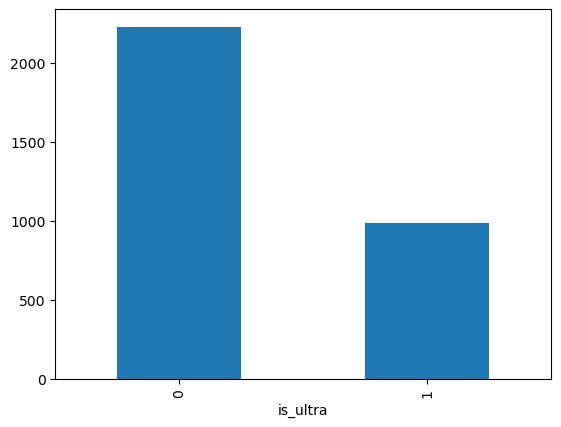

In [6]:
m_lines_frequency = df['is_ultra'].value_counts()
print(m_lines_frequency)
m_lines_frequency.plot(kind='bar')

It should be noted that the sample is not balanced. This factor must be taken into account when further training models.

## Data preparation

Let's divide the current dataset into 3 samples: the main, the validation and the test one. Before that, we will designate the target and other signs.

In [7]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra'] 


df_train, df_work = train_test_split(df, test_size=0.4, random_state=12345)

df_valid, df_test = train_test_split(df_work, test_size=0.4, random_state=12345)

Now we have 3 samples with target and other attributes:

1) df_train - training sample for training the model (60% of the total sample)

2) df_valid - validation sample for preliminary verification of models (20% of the total sample)

3) df_test is a test sample, according to which we will evaluate the model finally. (20% of the total sample)

## Model research

For further preparation and research of models, we will create variables with target and other features for previously prepared samples.

In [8]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']


Given that this is a classification task, let's consider 3 main models:

- Decision tree
- Random forest
- Logistic regression

**Decision tree**

Let's check Decision tree model without 'depth' tuning.

In [9]:
model_basic_tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_basic_tree.fit(features_train, target_train)

train_pred_basic_tree = model_basic_tree.predict(features_train)

valid_pred_basic_tree = model_basic_tree.predict(features_valid)

print("Accuracy")
print("test sample:", accuracy_score(target_train, train_pred_basic_tree))
print("validation sample:", accuracy_score(target_valid, valid_pred_basic_tree))

Accuracy
test sample: 1.0
validation sample: 0.7198443579766537


The training sample gives almost 100% accuracy, while the validation sample gives an accuracy of about 70%. 30% is a big difference, so we will select the tree depth parameter for this model.

Given that there are only 4 features (without a target) in the dataset, we will iterate through the depth of trees from 1 to 4 and select the most appropriate parameter.

In [10]:
best_model_dt = None
best_result_dt = 0
for depth in range(1, 4):
    model_depth_tree = DecisionTreeClassifier(random_state=12345, max_depth= depth, class_weight='balanced') 
    model_depth_tree.fit(features_train, target_train) 
    predictions = model_depth_tree.predict(features_valid) 
    result = accuracy_score(target_valid, predictions) 
    if result > best_result_dt:
        best_model_dt = model_basic_tree
        best_result_dt = result
        
print("Accuracy of the best model:", best_result_dt,'depth:', depth)

Accuracy of the best model: 0.7846952010376135 depth: 3


By increasing the depth of the tree to 3, the accuracy of the study increased by 9.2%. The gap between the training and validation samples has narrowed. Let's save the model.

In [11]:
model_depth_tree = DecisionTreeClassifier(random_state=12345, max_depth= 3, class_weight='balanced') 
model_depth_tree.fit(features_train, target_train)

train_pred_depth = model_depth_tree.predict(features_train)

valid_pred_depth = model_depth_tree.predict(features_valid)

print("Accuracy")
print("test sample:", accuracy_score(target_train, train_pred_depth))
print("validation sample:", accuracy_score(target_valid, valid_pred_depth))

Accuracy
test sample: 0.8054979253112033
validation sample: 0.7808041504539559


**Random forest**

Let's check Random forest classifier. First of all, we should determin the appropriate number of estimators. 

In [12]:
best_model_rf_v0 = None
best_result_v0 = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators= est, class_weight='balanced') 
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid) 
    if result > best_result_v0:
        best_model_v0 = model
        best_result_v0 = result

print("Accuracy of the best model (valid sample):", best_result_v0, 'number of trees:', est)

Accuracy of the best model (valid sample): 0.7769130998702983 number of trees: 10


At this stage, it can be seen that with the maximum number of trees, the accuracy is 78%. Let's try to increase the search of the number of trees to 50. The depth of trees from 1 to 4 was also sorted.

In [13]:
%%time
best_model_v1 = None
best_result_v1 = 0
best_depth_v1 = 0
for est in range(1, 51, 10):
    for depth in range(1,4):
        model = RandomForestClassifier(random_state=12345, n_estimators= est, max_depth = depth, class_weight='balanced') 
        model.fit(features_train, target_train) 
        result = model.score(features_valid, target_valid) 
        if result > best_result_v1:
            best_model_v1 = model
            best_result_v1 = result
            best_depth_v1 = depth

print("Accuracy of the best model (valid sample):", best_result_v1, 'number of trees:', est, 'depth:', depth )

Accuracy of the best model (valid sample): 0.788586251621271 number of trees: 41 depth: 3
CPU times: user 399 ms, sys: 3.93 ms, total: 403 ms
Wall time: 402 ms


The accuracy increased with an increase in the number of trees to 41 and a depth of 3. In this case, we will focus on the number of trees in the amount of 41.

We will save the model for further testing.

In [14]:
model_rand_for = RandomForestClassifier(random_state=12345, n_estimators= 41, max_depth =3, class_weight='balanced') 
model_rand_for.fit(features_train, target_train)

train_pred_rand = model_rand_for.predict(features_train)

valid_pred_rand = model_rand_for.predict(features_valid)

print("Accuracy")
print("test sample:", accuracy_score(target_train, train_pred_rand))
print("validation sample:", accuracy_score(target_valid, valid_pred_rand))

Accuracy
test sample: 0.8065352697095436
validation sample: 0.7821011673151751


An increase in the number of trees also leads to an increase in accuracy in the validation sample.

**Logistic regression**

In [15]:
model_log_regr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_log_regr.fit(features, target)

train_pred_log = model_log_regr.predict(features_train)
valid_pred_log = model_log_regr.predict(features_valid)

print("Accuracy")
print("test sample:", accuracy_score(target_train, train_pred_log))
print("validation sample:", accuracy_score(target_valid, valid_pred_log))

Accuracy
test sample: 0.7474066390041494
validation sample: 0.7613488975356679


Prediction accuracy on logistic regression is 76%. At the same time, the accuracy for the training sample decreased.
Let's try changing the max_iter parameter to 10000 and see how the accuracy changes.

In [16]:
model_log_regr_v2 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=10000) 
model_log_regr_v2.fit(features, target)

train_pred_log_v2 = model_log_regr_v2.predict(features_train)
valid_pred_log_v2 = model_log_regr_v2.predict(features_valid)

print("Accuracy")
print("test sample:", accuracy_score(target_train, train_pred_log_v2))
print("validation sample:", accuracy_score(target_valid, valid_pred_log_v2))

Accuracy
test sample: 0.7474066390041494
validation sample: 0.7613488975356679


Let's change "solver" - we will use "liblinear".

In [17]:
model_log_regr_v2 = LogisticRegression(random_state=12345, solver='liblinear', max_iter=10000) 
model_log_regr_v2.fit(features, target)

train_pred_log_v2 = model_log_regr_v2.predict(features_train)
valid_pred_log_v2 = model_log_regr_v2.predict(features_valid)

print("Accuracy")
print("test samle:", accuracy_score(target_train, train_pred_log_v2))
print("validation sample:", accuracy_score(target_valid, valid_pred_log_v2))

Accuracy
test samle: 0.7411825726141079
validation sample: 0.7587548638132295


The accuracy decreased slightly on the validation sample. At this stage, we will leave the algorithm l bfgs and max_iter = 1000.

**Conslusion - best model**

The highest accuracy in the validation sample of the random forest model with parameters n_estimators= 41, max_depth =3, class_weight='balanced'.

Next, we will use it to check the test sample.

## Test check

In [18]:
test_pred_depth = model_rand_for.predict(features_test)


print("Accuracy")
print("test sample:", accuracy_score(target_test, test_pred_depth))

Accuracy
test sample: 0.7922330097087379


## Checking the model for adequacy

In [19]:
from sklearn.dummy import DummyClassifier

d_model = DummyClassifier(strategy='prior', random_state=12345)
d_model.fit(features_train, target_train)

d_train_pred = d_model.predict(features_train)
d_valid_pred = d_model.predict(features_valid)
d_test_pred = d_model.predict(features_test)

print('Accuracy')
print('train sample:',d_model.score(features_train, target_train))
print('validation sample:',d_model.score(features_valid, target_valid))
print('test sample:',d_model.score(features_test, target_test))

Accuracy
train sample: 0.6924273858921162
validation sample: 0.7029831387808041
test sample: 0.683495145631068


## Results of the research

Based on the conducted research, the Decision Tree models with a depth of 3 and a Forest of Trees show themselves best.

The depth of the tree affects the accuracy of predictions. In this case, the greater the depth (up to a certain value) the higher the accuracy.

The accuracy of the Random Forest model reaches 79%.